In [159]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from IPython.display import display
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import random

### Data Prep

In [160]:
dataset = ImageFolder('data/cats_dogs/train/')
dataset.classes

['cats', 'dogs']

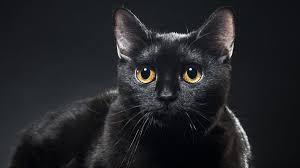

In [163]:
display(dataset[2][0])

In [164]:
len(dataset)

557

In [166]:
transform = transforms.Compose([transforms.Resize((255,255) ),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
train_dataset = ImageFolder('data/cats_dogs_sample/train/', transform = transform)

In [167]:
train_dataset[0][0].shape

torch.Size([3, 255, 255])

In [168]:
torch.concat((train_dataset[0][0],train_dataset[1][0]), dim = 1 ).shape

torch.Size([3, 510, 255])

In [169]:
torch_concatinated = torch.concat([data[0] for data in train_dataset], dim = 1)
torch_concatinated.shape

torch.Size([3, 15300, 255])

In [170]:
mean = torch.mean(torch_concatinated, dim = (1,2))
mean

tensor([0.5762, 0.5604, 0.4927])

In [171]:
std_dev =torch.std(torch_concatinated, dim = (1,2))
std_dev

tensor([0.3023, 0.2916, 0.3174])

In [172]:
additional_transform = transforms.Compose([
    transforms.Normalize(mean, std_dev)
])
train_dataset.transform.transforms.append(additional_transform)
additional_transform

Compose(
    Normalize(mean=tensor([0.5762, 0.5604, 0.4927]), std=tensor([0.3023, 0.2916, 0.3174]))
)

<Figure size 1000x1000 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


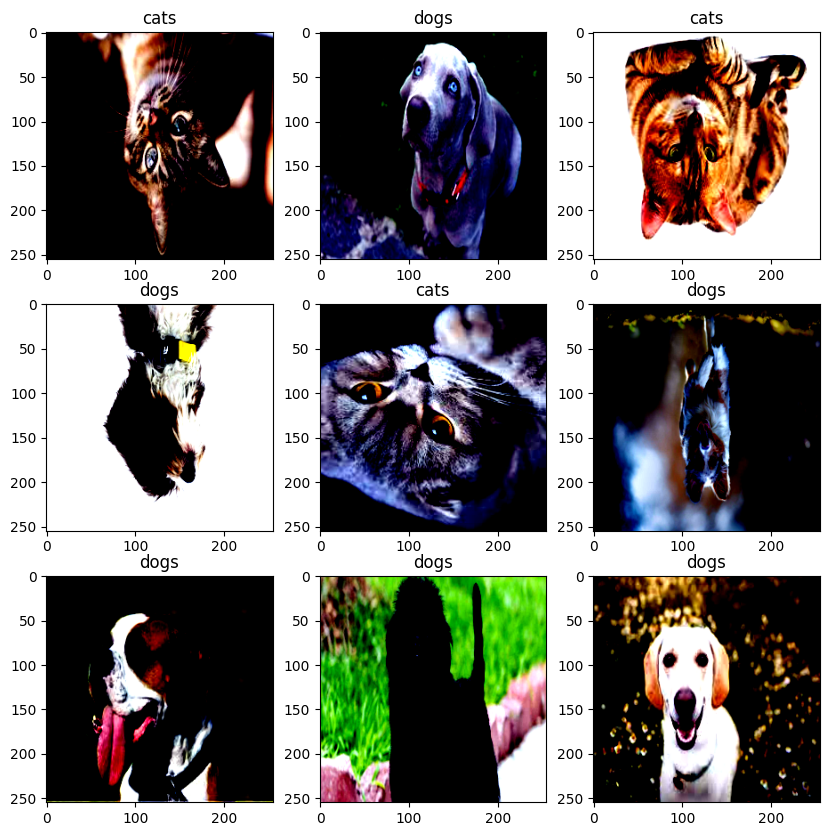

In [183]:
fig = plt.figure(figsize=(10,10))
cols = 3
rows =3
for i in range(1,cols*rows+1):
    idx = torch.randint(len(train_dataset),size=(1,)).item()
    img, label = train_dataset[idx]
    class_name = train_dataset.classes[label]
    fig.add_subplot(rows, cols, i)
    plt.title(class_name)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [184]:
test_dataset = ImageFolder('data/cats_dogs/test/', transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
    ,additional_transform
]))

In [185]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

### Arch design phase

In [186]:
class ConvBlock(nn.Module):
    def __init__(self,c_in_channels, c_out_channels, c_kernel_size, c_stride, c_padding,
                 b_num_features,
                 m_kernal=None,m_stride=None,) -> None:
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=c_in_channels, out_channels=c_out_channels, kernel_size=c_kernel_size, stride=c_stride, padding=c_padding)
        self.r1 = nn.ReLU(inplace=True)
        self.m1 = None
        if m_kernal is not None and m_stride is not None:
            self.m1 = nn.MaxPool2d(kernel_size=m_kernal, stride=m_stride)
        self.b1 = nn.BatchNorm2d(b_num_features)
    def forward(self,x):
        x = self.c1(x)
        x = self.r1(x)
        if self.m1:
            x = self.m1(x)
        x = self.b1(x)
        return x

In [187]:
class AlexNet(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        self.cb_1 = ConvBlock(3,96,11,4,2,96,3,2)
        self.cb_2 = ConvBlock(96,256,5,1,2,256,3,2)
        self.cb_3 = ConvBlock(256,384,3,1,1,384)
        self.cb_4 = ConvBlock(384,384,3,1,1,384)
        self.cb_5 = ConvBlock(384,256,3,1,1,256,3,2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.r1 = nn.ReLU(inplace=True)
        self.l1 = nn.Linear(256 * 6 * 6, 4096)
        self.l2 = nn.Linear(4096, 4096)
        self.out_layer = nn.Linear(4096, num_classes)
        self.d1 = nn.Dropout()
    def forward(self,x):
        x = self.cb_1(x)
        x = self.cb_2(x)
        x = self.cb_3(x)
        x = self.cb_4(x)
        x = self.cb_5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.d1(x)
        x = self.l1(x)
        x = self.r1(x)
        x = self.d1(x)
        x = self.l2(x)
        x = self.r1(x)
        x = self.out_layer(x)
        return x


### setting up hyper parameters

In [188]:
model = AlexNet(2)

In [190]:
device = "cpu"
model.to(device=device)

AlexNet(
  (cb_1): ConvBlock(
    (c1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (r1): ReLU(inplace=True)
    (m1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (b1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb_2): ConvBlock(
    (c1): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (r1): ReLU(inplace=True)
    (m1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (b1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb_3): ConvBlock(
    (c1): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r1): ReLU(inplace=True)
    (b1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb_4): ConvBlock(
    (c1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r1): ReLU(inplace=True)
    (b1): BatchNorm2d(384, 

In [191]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =  0.0001)

### training

In [192]:
train_accuracies = []
test_accuracies = []
num_epochs = 56
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / total_train
    
    train_accuracies.append(train_accuracy)
    # Evaluation (Test)
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate test accuracy and loss
    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test
    
    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")

100%|██████████| 15/15 [00:17<00:00,  1.13s/it]


Epoch 1/56 - Train Loss: 0.7231 - Train Acc: 0.5000 - Test Loss: 0.6926 - Test Acc: 0.5000


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 2/56 - Train Loss: 0.7002 - Train Acc: 0.5667 - Test Loss: 0.6922 - Test Acc: 0.5143


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 3/56 - Train Loss: 0.6926 - Train Acc: 0.5000 - Test Loss: 0.6924 - Test Acc: 0.5000


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 4/56 - Train Loss: 0.6816 - Train Acc: 0.5500 - Test Loss: 0.6895 - Test Acc: 0.5643


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 5/56 - Train Loss: 0.6994 - Train Acc: 0.4667 - Test Loss: 0.6900 - Test Acc: 0.5500


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 6/56 - Train Loss: 0.6888 - Train Acc: 0.5000 - Test Loss: 0.6887 - Test Acc: 0.5643


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 7/56 - Train Loss: 0.6864 - Train Acc: 0.5333 - Test Loss: 0.6880 - Test Acc: 0.5714


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 8/56 - Train Loss: 0.6940 - Train Acc: 0.5333 - Test Loss: 0.6877 - Test Acc: 0.5643


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 9/56 - Train Loss: 0.6823 - Train Acc: 0.5667 - Test Loss: 0.6875 - Test Acc: 0.5714


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 10/56 - Train Loss: 0.6692 - Train Acc: 0.6500 - Test Loss: 0.6874 - Test Acc: 0.5714


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 11/56 - Train Loss: 0.6816 - Train Acc: 0.5500 - Test Loss: 0.6860 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 12/56 - Train Loss: 0.6893 - Train Acc: 0.5167 - Test Loss: 0.6868 - Test Acc: 0.5857


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 13/56 - Train Loss: 0.6848 - Train Acc: 0.5333 - Test Loss: 0.6867 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 14/56 - Train Loss: 0.6782 - Train Acc: 0.6667 - Test Loss: 0.6866 - Test Acc: 0.5714


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 15/56 - Train Loss: 0.6568 - Train Acc: 0.6500 - Test Loss: 0.6859 - Test Acc: 0.6143


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 16/56 - Train Loss: 0.6785 - Train Acc: 0.5500 - Test Loss: 0.6856 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 17/56 - Train Loss: 0.6802 - Train Acc: 0.5833 - Test Loss: 0.6857 - Test Acc: 0.5857


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 18/56 - Train Loss: 0.6883 - Train Acc: 0.6167 - Test Loss: 0.6857 - Test Acc: 0.5929


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 19/56 - Train Loss: 0.6698 - Train Acc: 0.6667 - Test Loss: 0.6848 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 20/56 - Train Loss: 0.6688 - Train Acc: 0.6167 - Test Loss: 0.6851 - Test Acc: 0.5714


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


Epoch 21/56 - Train Loss: 0.6628 - Train Acc: 0.7167 - Test Loss: 0.6849 - Test Acc: 0.5643


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 22/56 - Train Loss: 0.6671 - Train Acc: 0.6167 - Test Loss: 0.6847 - Test Acc: 0.5643


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 23/56 - Train Loss: 0.6808 - Train Acc: 0.5833 - Test Loss: 0.6844 - Test Acc: 0.5714


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 24/56 - Train Loss: 0.6683 - Train Acc: 0.6000 - Test Loss: 0.6842 - Test Acc: 0.5786


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 25/56 - Train Loss: 0.6667 - Train Acc: 0.6667 - Test Loss: 0.6836 - Test Acc: 0.5929


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 26/56 - Train Loss: 0.6669 - Train Acc: 0.6333 - Test Loss: 0.6838 - Test Acc: 0.5857


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 27/56 - Train Loss: 0.6725 - Train Acc: 0.6000 - Test Loss: 0.6834 - Test Acc: 0.5929


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 28/56 - Train Loss: 0.6828 - Train Acc: 0.5333 - Test Loss: 0.6837 - Test Acc: 0.5571


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 29/56 - Train Loss: 0.6563 - Train Acc: 0.7000 - Test Loss: 0.6839 - Test Acc: 0.5786


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Epoch 30/56 - Train Loss: 0.6543 - Train Acc: 0.6667 - Test Loss: 0.6839 - Test Acc: 0.5857


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 31/56 - Train Loss: 0.6601 - Train Acc: 0.5833 - Test Loss: 0.6823 - Test Acc: 0.5857


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 32/56 - Train Loss: 0.6527 - Train Acc: 0.7000 - Test Loss: 0.6826 - Test Acc: 0.5929


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 33/56 - Train Loss: 0.6599 - Train Acc: 0.6333 - Test Loss: 0.6832 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 34/56 - Train Loss: 0.6457 - Train Acc: 0.7167 - Test Loss: 0.6833 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 35/56 - Train Loss: 0.6506 - Train Acc: 0.6500 - Test Loss: 0.6827 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 36/56 - Train Loss: 0.6478 - Train Acc: 0.7000 - Test Loss: 0.6819 - Test Acc: 0.6071


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 37/56 - Train Loss: 0.6464 - Train Acc: 0.6667 - Test Loss: 0.6823 - Test Acc: 0.5929


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Epoch 38/56 - Train Loss: 0.6495 - Train Acc: 0.7667 - Test Loss: 0.6824 - Test Acc: 0.5857


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 39/56 - Train Loss: 0.6561 - Train Acc: 0.6667 - Test Loss: 0.6827 - Test Acc: 0.6000


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Epoch 40/56 - Train Loss: 0.6744 - Train Acc: 0.6167 - Test Loss: 0.6833 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Epoch 41/56 - Train Loss: 0.6354 - Train Acc: 0.7667 - Test Loss: 0.6821 - Test Acc: 0.6000


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 42/56 - Train Loss: 0.6637 - Train Acc: 0.6333 - Test Loss: 0.6824 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 43/56 - Train Loss: 0.6470 - Train Acc: 0.7167 - Test Loss: 0.6812 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 44/56 - Train Loss: 0.6576 - Train Acc: 0.6167 - Test Loss: 0.6816 - Test Acc: 0.5929


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Epoch 45/56 - Train Loss: 0.6385 - Train Acc: 0.7333 - Test Loss: 0.6809 - Test Acc: 0.5929


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 46/56 - Train Loss: 0.6313 - Train Acc: 0.7000 - Test Loss: 0.6808 - Test Acc: 0.5929


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 47/56 - Train Loss: 0.6480 - Train Acc: 0.6333 - Test Loss: 0.6807 - Test Acc: 0.5929


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Epoch 48/56 - Train Loss: 0.6417 - Train Acc: 0.7000 - Test Loss: 0.6813 - Test Acc: 0.5857


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 49/56 - Train Loss: 0.6348 - Train Acc: 0.7000 - Test Loss: 0.6809 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 50/56 - Train Loss: 0.6716 - Train Acc: 0.6500 - Test Loss: 0.6796 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Epoch 51/56 - Train Loss: 0.6514 - Train Acc: 0.7167 - Test Loss: 0.6795 - Test Acc: 0.6000


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


Epoch 52/56 - Train Loss: 0.6378 - Train Acc: 0.7333 - Test Loss: 0.6800 - Test Acc: 0.5857


100%|██████████| 15/15 [00:27<00:00,  1.87s/it]


Epoch 53/56 - Train Loss: 0.6484 - Train Acc: 0.6500 - Test Loss: 0.6802 - Test Acc: 0.5929


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 54/56 - Train Loss: 0.6111 - Train Acc: 0.8000 - Test Loss: 0.6796 - Test Acc: 0.5857


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 55/56 - Train Loss: 0.6330 - Train Acc: 0.7167 - Test Loss: 0.6793 - Test Acc: 0.5857


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 56/56 - Train Loss: 0.6363 - Train Acc: 0.7333 - Test Loss: 0.6803 - Test Acc: 0.5643


In [193]:
torch.save(model.state_dict(),"model/base_model_v1.pth")

### Prediction

In [194]:
loaded_model = AlexNet(2)
loaded_model.load_state_dict(torch.load("model/base_model_v1.pth"))

<All keys matched successfully>

In [195]:
additional_transform

Compose(
    Normalize(mean=tensor([0.5762, 0.5604, 0.4927]), std=tensor([0.3023, 0.2916, 0.3174]))
)

In [196]:
class ClassPredictor:
    def __init__(self,model,class_map) -> None:
        self.model = model
        self.class_map = class_map
    def preprocess(self,img_path):
        preprocess =transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.ToTensor()
            ,transforms.Normalize(mean=[0.5762, 0.5604, 0.4927], std=[0.3023, 0.2916, 0.3174])
        ])
        image = Image.open(img_path).convert("RGB")
        image = preprocess(image)
        image = image.unsqueeze(0)
        return image
    def model_pred(self,img_tensor):
        self.model.eval()
        with torch.no_grad():
            output = self.model(img_tensor)
        _, pred_class = output.max(1)
        return self.class_map[pred_class.item()]
    def predict(self,img_path):
        img_tensor = self.preprocess(img_path=img_path)
        return self.model_pred(img_tensor=img_tensor)

In [197]:
class_map = {
    0:"cat",
    1:"dog"
}
pred_obj = ClassPredictor(model=model,class_map=class_map)

In [202]:
img_path = 'data/cats_dogs/test/cats/cat_114.jpg'
pred_obj.predict(img_path)

'cat'

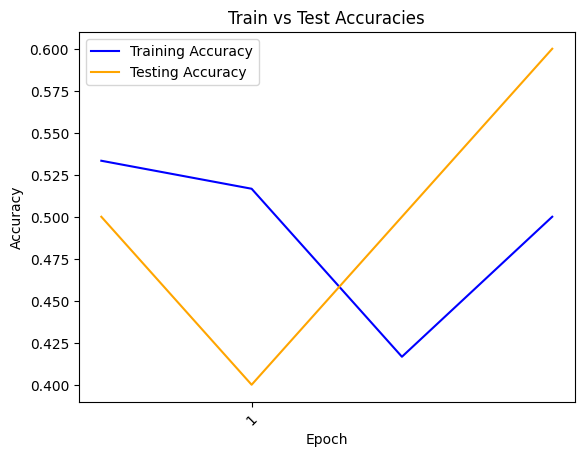

In [157]:
sns.lineplot(x = range(4), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(4), y = test_accuracies, color = "orange", label = "Testing Accuracy")
plt.title("Train vs Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,4,10), rotation = 45)
plt.yticks(label = range(1,4,15))
plt.legend()
plt.show()